## Data Cleaning:  LDS Missionary Database

Data gathered from https://history.churchofjesuschrist.org/chd/search?tabFacet=people&tabSubfacet=missionaries&lang=eng
* Filtering for missionaries (~46,942 pages currently listed)
* Features extracted:  missionary name, mission name, departure year, mission type, missionary residence before departure)
* Missionary name may show up mulitple times (once per mission served)



In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data and Remove Duplicates

The web scraper was run in stages, so the data set is spread across multiple files. We will first read in all files and combine them into a single data frame:
* All files use the same headers, so we can employ `df.concat`
* Special encoding used to match the CSV file 


In [29]:
file_ends = ["0", "5000", "10000", "14000", "18000", "22000", "26000", "30500", "36000", "40000", "44000", "extra"]

df = pd.read_csv("missionary_data/mission_info_0.csv", encoding="ISO-8859-1")

for i in range(1, len(file_ends)):
    new_df = pd.read_csv(f"missionary_data/mission_info_{file_ends[i]}.csv", encoding="ISO-8859-1")
    df = pd.concat([df, new_df])
    
df.head()

,name,mission,year,type,residence
0,Lyman Palmer Pinkston,Central States Mission,1931,Proselytizing,"Glendale, California"
1,Nelson Daniel Russ,Eastern States Mission,1898,Proselytizing,"Wilford, Fremont, Idaho, United States"
2,Preston Baxter Maughan,Northwestern States (Pacific) Mission,1919,NaN,"Wellsville, Cache, Utah, United States"
3,Joseph Ezra Wood,British Mission,1912,NaN,"Holden, Millard, Utah, United States"
4,Jens Wilhelm Olsen,Danish Mission,1935,NaN,United States


Some duplicate rows may appear in the data set. We will use the `drop_duplicates` method in Pandas to take care of them:

In [30]:
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))

53379
53314


To give us an easier place to start next time, we will export the data frame to a file:

In [32]:
df.to_csv("mission_info_all.csv", index=False)

### Dealing with Missing Values

First we might want to see a distribution of missionary departures by year. We can start by converting years to integer types:

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53314 entries, 0 to 48
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       53314 non-null  object
 1   mission    53314 non-null  object
 2   year       53314 non-null  object
 3   type       35064 non-null  object
 4   residence  51087 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


In [34]:
df["year"] = df["year"].apply(lambda x:  int(x))

ValueError: invalid literal for int() with base 10: '?'

Oof, it looks like some entries in the `year` column aren't actually numeric. Let's print out the ones that aren't numeric to see what's going on:

In [36]:
def is_int(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

for i in range(len(df)):
    if not is_int(df.iloc[i].year):
        print(i, df.iloc[i]['name'], df.iloc[i].year)
    

2195 Winfield Scott Harris ?
3786 Franklin Jay Bradshaw No
4778 William E McClellin No
12234 Hans M Bottcher No
12826 Jane McKinnon No
13031 Ann Morris No
13582 Thomas Barnabee Bennett ?
13946 Jedediah Grant Lambert No
13995 Enoch Jorgensen ?
14971 Zamri C Kitchens No


The good news is that only a few entries have non-integer values. We could look up the missionaries online to see if there was a problem in data extraction. But since these are only a few out of over 50,000 entries, we can safely ignore them for our distribution plot:

In [40]:
filter_col = df["year"].apply(is_int)

years_filter = df[filter_col]

print(len(years_filter))


53304


In [41]:
# convert data types now
years_filter["year"] = years_filter["year"].apply(lambda x:  int(x))

print(years_filter["year"].min(), years_filter["year"].max())

1830 1994


C:\Users\10502190\AppData\Local\Temp\ipykernel_11364\3486629052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_filter["year"] = years_filter["year"].apply(lambda x:  int(x))


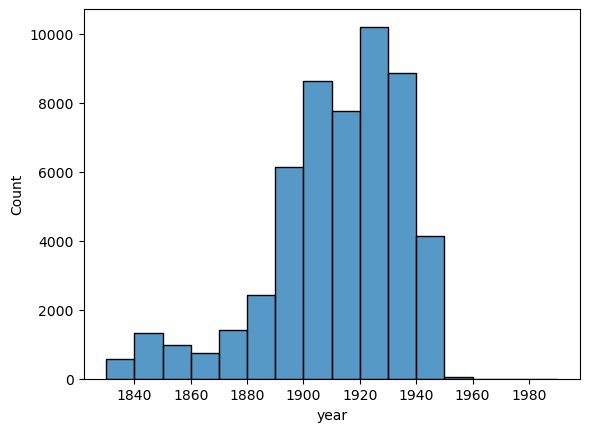

In [47]:
### Create distribution plot
fig, ax = plt.subplots()
sns.histplot(years_filter["year"], bins=range(1830, 2000, 10))
plt.show()

### Exploring Features:  Mission Name

Next we will look at the `mission` column. First let's see how many unique mission names there are in the data set. We can accomplish this with a Python dictionary:

In [49]:
mission_counts = {}

for i in range(len(df)):
    cur_mission = df.iloc[i]["mission"]
    if cur_mission in mission_counts:
        mission_counts[cur_mission] += 1
    else:
        mission_counts[cur_mission] = 1
        
print(len(mission_counts))

84


84 mission names is not so bad. Let's get a sense of how many missionaries were assigned to each mission:
* Print out the unique mission names
* Sort by number of missionaries (high to low)

In [52]:
mission_sort = []
for k, v in mission_counts.items():
    mission_sort.append((v, k)) # count, then mission name
mission_sort.sort(reverse=True)

for item in mission_sort:
    print(f"{item[1]}:  {item[0]}")

Southern States Mission:  6681
British Mission:  6282
Eastern States Mission:  4627
Northern States Mission:  4070
Central States Mission:  3517
California Mission:  2786
Northwestern States (Pacific) Mission:  2426
Swiss and German Mission:  2233
Western States Mission:  1904
Scandinavian Mission:  1816
Early Church Mission: North America :  1176
Hawaiian Mission:  1010
Canadian Mission:  943
Netherlands Mission:  883
North Central States Mission:  856
East Central States Mission:  798
New Zealand Mission:  791
Mexican Mission:  730
Danish-Norwegian Mission:  680
Australian Mission:  661
Texas Mission:  654
Swedish Mission:  633
German and Austrian Mission:  610
Spanish American Mission:  433
Samoan Mission:  425
German Mission:  367
French Mission:  358
Joseph Smith Presidential Campaign Mission:  352
South African Mission:  337
Danish Mission:  305
Colorado Mission:  297
Indian Territory Mission:  291
The Tabernacle Choir at Temple Square Mission:  280
Australasian Mission:  264
New

If desired, we can repeat this exercise with restrictions on date (e.g. 1850 to 1900). 

Those familiar with LDS mission history will note that mission names have changed over time (usually splitting from larger mission areas into smaller ones). One area of interest is Scandinavia, which includes Denmark, Finland, Iceland, Norway, and Sweden. The Scandinavian Mission split into the Danish-Norwegian Mission and the Swedish Mission in 1905:
* https://history.churchofjesuschrist.org/chd/organization/mission/scandinavian-1850?lang=eng 

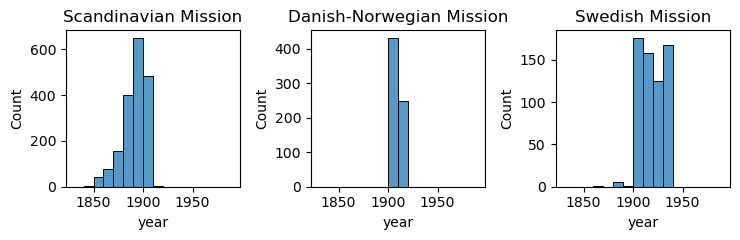

In [68]:
mission_filter = ["Scandinavian Mission", "Danish-Norwegian Mission", "Swedish Mission"]

fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))

for i in range(3):
    sns.histplot(years_filter[years_filter["mission"] == mission_filter[i]]["year"], bins=range(1830, 2000, 10), ax = axes[i])
    axes[i].set_title(mission_filter[i])

plt.tight_layout()
plt.show()



Now let's filter by missions containing the name "States" with at least 100 participants and view their distribution by year. 

['Central States Mission', 'Eastern States Mission', 'Northwestern States (Pacific) Mission', 'Northern States Mission', 'Southern States Mission', 'Western States Mission', 'North Central States Mission', 'Middle States Mission', 'East Central States Mission']


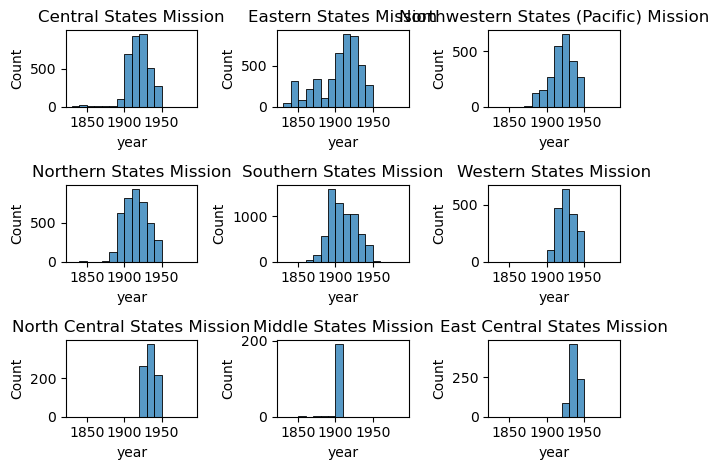

In [56]:
states_mission_filter = []
for k in mission_counts:
    if "State" in k and mission_counts[k] >= 100:
        states_mission_filter.append(k)

print(states_mission_filter)

fig, axes = plt.subplots(3, 3)

for i in range(9):
    a, b = divmod(i, 3)
    sns.histplot(years_filter[years_filter["mission"] == states_mission_filter[i]]["year"], bins=range(1830, 2000, 10), ax = axes[a][b])
    axes[a][b].set_title(states_mission_filter[i])

plt.tight_layout()
plt.show()



We can at least see that certain missions began later, such as the Western, North Central, and East Central States missions. Some additional historical research may be needed to determine geographic hierarchy among missions, including those covering smaller regions or individual states (e.g. New England, Texas, California). 

### Exploring Features:   Mission Type

Now we'll look at the `type` column, which also happens to have the most missing values:

In [69]:
mission_counts = {}

for i in range(len(df)):
    cur_mission = df.iloc[i]["type"]
    if cur_mission in mission_counts:
        mission_counts[cur_mission] += 1
    else:
        mission_counts[cur_mission] = 1
        
print(len(mission_counts))

mission_sort = []
for k, v in mission_counts.items():
    mission_sort.append((v, k)) # count, then mission name
mission_sort.sort(reverse=True)

for item in mission_sort:
    print(f"{item[1]}:  {item[0]}")

7
Proselytizing:  33736
nan:  18250
Other:  647
Short Term:  552
Education:  85
Geneology:  30
Genealogy:  14


The majority of missions listed are "Proselytizing", and the next largest chunk is unspecified. Note that there is a spelling discrepancy between "Geneology" and "Genealogy". If needed, we could filter out the mission types that are labelled as something other than "Proselytizing" (but keep the null values just in case). 

### Exploring Features:  Missionary Residence

Now here comes the fun part. One of my goals in this project is to find link (or lack of links) between where a missionary lived at the time of a mission call and where they were assigned to serve. To do that, I need a better idea of how many residence locations there are:

In [70]:
mission_counts = {}

for i in range(len(df)):
    cur_mission = df.iloc[i]["residence"]
    if cur_mission in mission_counts:
        mission_counts[cur_mission] += 1
    else:
        mission_counts[cur_mission] = 1
        
print(len(mission_counts))

mission_sort = []
for k, v in mission_counts.items():
    mission_sort.append((v, k)) # count, then mission name
mission_sort.sort(reverse=True)

for item in mission_sort[:100]: # only print the top 100 locations 
    print(f"{item[1]}:  {item[0]}")

6994
Salt Lake City, Salt Lake, Utah, United States:  4358
United States:  4080
nan:  2227
Ogden, Weber, Utah, United States:  883
Logan, Cache, Utah, United States:  797
Salt Lake City, Salt Lake, Utah Territory, United States:  763
Provo, Utah, Utah, United States:  755
Brigham City, Box Elder, Utah, United States:  458
Nauvoo, Hancock, Illinois, United States:  362
Lehi, Utah, Utah, United States:  259
Spanish Fork, Utah, Utah, United States:  248
Smithfield, Cache, Utah, United States:  239
Hyrum, Cache, Utah, United States:  226
Salt Lake, Utah, United States:  220
Great Salt Lake City, Great Salt Lake, Utah Territory, United States:  220
American Fork, Utah, Utah, United States:  216
Richfield, Sevier, Utah, United States:  209
Pleasant Grove, Utah, Utah, United States:  203
Vernal, Uintah, Utah, United States:  199
Preston, Oneida, Idaho, United States:  194
Nephi, Juab, Utah, United States:  188
Ogden, Utah, United States:  183
Rexburg, Madison, Idaho, United States:  182
Richm

This is probably the messiest feature of the data set. Notice that Salt Lake is represented directly multiple times, for example:
* Salt Lake City, Salt Lake, Utah, United States:  4358
* Salt Lake City, Salt Lake, Utah Territory, United States:  763
* Salt Lake, Utah, United States:  220
* Great Salt Lake City, Great Salt Lake, Utah Territory, United States:  220

We also have over 2000 null values, plus 4000 values listed as just "United States". 

To clean up this column, we can first try to apply common identifiers to the same cities of residence. Let's search for all places that contain "Salt Lake":

In [75]:
for k in mission_counts:
    if type(k) == str and "salt lake" in k.lower(): 
        print(k)

Salt Lake City, Salt Lake, Utah, United States
Herriman, Salt Lake, Utah, United States
East Jordan, Salt Lake, Utah, United States
Butler, Salt Lake, Utah, United States
Draper, Salt Lake, Utah Territory, United States
Salt Lake, Utah, United States
Salt Lake City, Utah
Salt Lake City, Salt Lake, Utah Territory, United States
Capitol Hill, Salt Lake
Salt Lake City
Great Salt Lake City, Great Salt Lake, Utah Territory, United States
Pleasant Green, Salt Lake, Utah, United States
Draper, Salt Lake, Utah, United States
East Mill Creek, Salt Lake, Utah, United States
Murray, Salt Lake, Utah, United States
Salt Lake City 11th, Emigration
Salt Lake City 26th, Pioneer
Hunter, Salt Lake, Utah, United States
Millcreek, Salt Lake, Utah, United States
Mill Creek, Salt Lake, Utah, United States
Great Salt Lake City, Salt Lake, Utah Territory, United States
Sugar House Ward, Salt Lake, Utah, United States
South Salt Lake City 20th, Ensign
City, Salt Lake, Utah, United States
Miller, South Salt Lak

Some issues include:
* Salt Lake being a city name and a county name
* Some locations being lumped in with Salt Lake incorrectly (e.g. St. George, Beaver)

We may decide to include everything in "Salt Lake Valley" together in the Salt Lake group (e.g. Sandy, Draper, Murray, West Jordan, etc.), and filter out the handful of entries that are definitely not within the valley. 

To deal with null values, let's gather the corresponding missionary names to see if they have any other non-null residence values (they may have served in multiple missions, or have been transferred): 

In [79]:
null_missionaries = []

for i in range(len(df)):
    if not type(df.iloc[i]["residence"]) == str:
        null_missionaries.append(df.iloc[i]["name"])
        
null_missionaries = set(null_missionaries)
print(len(null_missionaries))

for m in null_missionaries:
    cur_df = df.loc[df["name"] == m]
    if len(cur_df) > 1:
        print(cur_df["residence"])
        print()

1881
2421    Lehi 4th Lehi
2422              NaN
Name: residence, dtype: object

1594    Burton ward, Wells stake
1595                         NaN
Name: residence, dtype: object

3317                                               NaN
3318    Salt Lake City, Salt Lake, Utah, United States
3319         Wasatch, Sugar House, Utah, United States
Name: residence, dtype: object

4254                                            NaN
4255           Montpelier, Bear Lake, United States
4256    Montpelier, Bear Lake, Idaho, United States
Name: residence, dtype: object

1441    Santa Ana Long Beach
1442                     NaN
Name: residence, dtype: object

5833                                        United States
5834                                        United States
5835    Salt Lake City, Salt Lake, Utah Territory, Uni...
5836    Salt Lake City, Salt Lake, Utah Territory, Uni...
5837                                                  NaN
Name: residence, dtype: object

4658    Ephraim, Sanpete

4575    NaN
4576    NaN
Name: residence, dtype: object

3018                  Hooper, United States
3019     Hooper, Weber, Utah, United States
3021    Hooper, Weber, Utah, United Statess
3022                          United States
3023                          United States
3024                          United States
3025                                    NaN
2610     Hooper, Weber, Utah, United States
Name: residence, dtype: object

1716    Ogden 4th Ward, Ogden Stake
1717                            NaN
1718                            NaN
Name: residence, dtype: object

4095    Logan, Cache, Utah, United States
4096    Logan, Cache, Utah, United States
4097                                  NaN
Name: residence, dtype: object

5408        Logan, Cache, Utah, United States
5409    Logan, Salt Lake, Utah, United States
5410                                      NaN
Name: residence, dtype: object

5175         Utah Territory, United States
5176    Northern California, United States
5177  

3759    Salt Lake, Utah, United States
3760                               NaN
Name: residence, dtype: object

286                                        NaN
287          Ogden, Weber, Utah, United States
288    Harrisville, Weber, Utah, United States
Name: residence, dtype: object

4880    Marysville, California, United States
4881                                      NaN
Name: residence, dtype: object

1295    Ogden 18th Mt Ogden
1296                    NaN
Name: residence, dtype: object

2144    Salt Lake City, Salt Lake, Utah, United States
2145                                               NaN
Name: residence, dtype: object

2321    27th Ensign
2322            NaN
Name: residence, dtype: object

5281    Salt Lake City, Salt Lake, Utah, United States
5282                                               NaN
5283    Salt Lake City, Salt Lake, Utah, United States
Name: residence, dtype: object

3636    Santa Ana Long Beach
3637                     NaN
Name: residence, dtype: object

1717

2920      Nauvoo, Hancock, Illinois, United States
2921                                           NaN
2922    Kanab, Kane, Utah Territory, United States
Name: residence, dtype: object

1716    Cedar City, Iron, Utah, United States
1717                                      NaN
Name: residence, dtype: object

1669                                               NaN
1670    Salt Lake City, Salt Lake, Utah, United States
1671    Salt Lake City, Salt Lake, Utah, United States
1672    Salt Lake City, Salt Lake, Utah, United States
Name: residence, dtype: object

3660    Provo, Utah, Utah Territory, United States
4342                                           NaN
Name: residence, dtype: object

1588    NaN
1589    NaN
Name: residence, dtype: object

4311    East Bountiful, Davis, Utah Territory, United ...
5319                                                  NaN
4438                    Logan, Cache, Utah, United States
348              Nauvoo, Hancock, Illinois, United States
349              

3242    NaN
3203    NaN
Name: residence, dtype: object

2719    United States
2720              NaN
Name: residence, dtype: object

3973                     Missouri, United States
3974                                    Missouri
3975                                         NaN
3976                                    Missouri
3977    Nauvoo, Hancock, Illinois, United States
3978    Nauvoo, Hancock, Illinois, United States
3979    Nauvoo, Hancock, Illinois, United States
Name: residence, dtype: object

4384    Nauvoo, Hancock, Illinois
4385                          NaN
Name: residence, dtype: object

507                                       NaN
508    Rexburg, Fremont, Idaho, United States
Name: residence, dtype: object

4327    United States
4328              NaN
Name: residence, dtype: object

906    Twin Falls 2nd Twin Falls
907                          NaN
Name: residence, dtype: object

761    Salt Lake City, Salt Lake, Utah, United States
762                                      

2071    NaN
2072    NaN
Name: residence, dtype: object

2012                                           NaN
2013                                           NaN
2014      Nauvoo, Hancock, Illinois, United States
2015                                           NaN
2016    Provo, Utah, Utah Territory, United States
Name: residence, dtype: object

2965    4th Ward, Salt Lake City, Utah, United States
2966                                              NaN
Name: residence, dtype: object

2103                       NaN
2104        Chenango, New York
2105    Kirtland, Geauga, Ohio
2106                       NaN
2107                       NaN
2109                       NaN
Name: residence, dtype: object

1760     Orange, Cuyahoga, Ohio
1761    Orange, Cuyahoga , Ohio
1762     Independence, Missouri
1763             Kirtland, Ohio
1764                        NaN
1765             Kirtland, Ohio
1766                        NaN
1767                       Ohio
1768                        NaN
1769       

3822    Salt Lake City, Salt Lake, Utah, United States
3823                                               NaN
Name: residence, dtype: object

4260                                                  NaN
4261                                                  NaN
4262                                                  NaN
4263    Salt Lake City, Salt Lake, Utah Territory, Uni...
Name: residence, dtype: object

1357    NaN
1358    NaN
Name: residence, dtype: object

1545    United States
1546              NaN
Name: residence, dtype: object

317    Provo 2nd Utah
318               NaN
Name: residence, dtype: object

1157    Spanish Fork 2nd Ward, Palmyra Stake, Utah
1158                                           NaN
Name: residence, dtype: object

3147                                               NaN
3148    Salt Lake City, Salt Lake, Utah, United States
Name: residence, dtype: object

65    Cannon Pioneer
66               NaN
Name: residence, dtype: object

3664    Jefferson Wells
3665        

1755    Salt Lake City, Salt Lake, Utah Territory, Uni...
1756       Salt Lake City, Salt Lake, Utah, United States
1757                                                  NaN
Name: residence, dtype: object

2462    Alamo
2463      NaN
Name: residence, dtype: object

5388                                                  NaN
5389    Salt Lake City, Salt Lake, Utah Territory, Uni...
Name: residence, dtype: object

2292                                                  NaN
2293    Salt Lake City, Salt Lake, Utah Territory, Uni...
Name: residence, dtype: object

4784    Oakley, Utah, United States
4785                            NaN
Name: residence, dtype: object

2797                                               NaN
2798    Salt Lake City, Salt Lake, Utah, United States
Name: residence, dtype: object

2081                                                  NaN
2082    Cache Valley, Sevier, Utah Territory, United S...
Name: residence, dtype: object

2499                                NaN
2500

441    Twim Falls, Twim Falls StakeUnited States
442                                          NaN
Name: residence, dtype: object

3536    Brigham 3rd Box, Elder, Utah
3537                             NaN
Name: residence, dtype: object

4057                                                  NaN
4058    St. George, Washington, Utah Territory, United...
Name: residence, dtype: object

677                Kirtland, Geauga, Ohio, United States
678                Kirtland, Geauga, Ohio, United States
679                                                  NaN
680    Salt Lake City, Salt Lake, Utah Territory, Uni...
Name: residence, dtype: object

479              Mendon, Monroe, New York, United States
480                Kirtland, Geuaga, Ohio, United States
481                Kirtland, Geuaga, Ohio, United States
482             Nauvoo, Hancock, Illinois, United States
483                                                  NaN
484    Salt Lake City, Salt Lake, Utah Territory, Uni...
Name: residenc

3869    Illinois, United States
3870                        NaN
3871        Utah, United States
3872                        NaN
Name: residence, dtype: object

3708    NaN
3709    NaN
Name: residence, dtype: object

5484    Burton, Idaho
5485              NaN
Name: residence, dtype: object

3314    Cedar City, Iron, Utah, United States
3315                                      NaN
Name: residence, dtype: object

4560    Pine Maricopa
4561              NaN
Name: residence, dtype: object

1510    Salt Lake City, Salt Lake, Utah, United States
1511                                               NaN
Name: residence, dtype: object

6110    Manavu Ward, Utah Stake, United States
6111                                       NaN
Name: residence, dtype: object

2459                                                  NaN
2460                                                  NaN
2461    Salt Lake City, Great Salt Lake, Utah Territor...
Name: residence, dtype: object

3228    Salt Lake City, Salt Lake,

659    Sameden, Switzerland
660                     NaN
Name: residence, dtype: object

392    Ogden, Weber, Utah, United States
393                                  NaN
394                    21st ward, Ensign
Name: residence, dtype: object

4519              NaN
4520    United States
4521              NaN
Name: residence, dtype: object

2354    Iona Idaho Falls
2355                 NaN
Name: residence, dtype: object

5285    Bryan Highland
5286               NaN
Name: residence, dtype: object

2595                                      NaN
2596    Ephraim, Sanpete, Utah, United States
Name: residence, dtype: object

4241    NaN
4242    NaN
Name: residence, dtype: object

867    Burton, Fremont, Idaho, United States
868                                      NaN
Name: residence, dtype: object

405    NaN
406    NaN
Name: residence, dtype: object

1009    Clifton, Idaho, United States
1010                              NaN
Name: residence, dtype: object

133    Idaho Falls, Idaho
134      

4391    United States
4392              NaN
Name: residence, dtype: object

1826                  Provo, Utah, Utah, United States
1827    Salt Lake City, Salt Lake, Utah, United States
1828                                               NaN
Name: residence, dtype: object

4199                NaN
4200    Winter Quarters
Name: residence, dtype: object

656    NaN
657    NaN
Name: residence, dtype: object

3701                                         NaN
3702    Nauvoo, Hancock, Illinois, United States
Name: residence, dtype: object

4236                     Levan, Juab, Utah, United States
74                                                    NaN
75           Brigham City, Box Elder, Utah, United States
882     Gentile Valley, Bannock, Idaho Territory, Unit...
2566                 Moroni, Sanpete, Utah, United States
2567                 Moroni, Sanpete, Utah, United States
Name: residence, dtype: object

3635    England, United Kingdom
3636                        NaN
Name: residence, dt

358    Salt Lake City, Utah, United States
359                                    NaN
Name: residence, dtype: object

2575                                               NaN
2576    Salt Lake City, Salt Lake, Utah, United States
Name: residence, dtype: object

1430    Ogden, Weber, Utah Territory, United States
2126                                            NaN
Name: residence, dtype: object

369              NaN
370              NaN
371    United States
Name: residence, dtype: object

4266    United States
4267              NaN
Name: residence, dtype: object

20               NaN
21               NaN
22    Kirtland, Ohio
23               NaN
25               NaN
26               NaN
Name: residence, dtype: object

2410    Kirtland, Geauga, Ohio
2411                    Nauvoo
2412                    Nauvoo
2413                       NaN
Name: residence, dtype: object

3465                                                 NaN
3466            Nauvoo, Hancock, Illinois, United States
3467 

4830                                                  NaN
4831    Great Salt Lake City, Great Salt Lake, Utah Te...
Name: residence, dtype: object

2311                  Provo, Utah, Utah, United States
2312    Salt Lake City, Salt Lake, Utah, United States
2313                                               NaN
Name: residence, dtype: object

1694    Auburn Ward, Star Valley Stake
1695                               NaN
Name: residence, dtype: object

2395                                        United States
2396                                                  NaN
2397                            Nauvoo, Hancock, Ilinois.
2398                                                  NaN
2399                                Winter Quarters, Iowa
2400    Brigham City, Box Elder, Utah Territory, Unite...
Name: residence, dtype: object

168                                                  NaN
169    Great Salt Lake City, Great Salt Lake, Utah Te...
170    Salt Lake City, Salt Lake, Utah Territory, U

1233    Ephraim No Ward, So Sanpete Stake
1234                                  NaN
Name: residence, dtype: object

3914          Kirtland
3915    Florence, Ohio
3916               NaN
3917          Kirtland
3918          Far West
Name: residence, dtype: object

4080    NaN
4082    NaN
4083    NaN
4084    NaN
Name: residence, dtype: object

2221    NaN
2222    NaN
Name: residence, dtype: object

3410    Whitney
3411        NaN
Name: residence, dtype: object

1498                                               NaN
1499    Salt Lake City, Salt Lake, Utah, United States
Name: residence, dtype: object

2186    Willard, Box Elder, Utah, United States
2188                                        NaN
Name: residence, dtype: object

4431                Kirtland, Geauga, Ohio, United States
4432             Nauvoo, Hancock, Illinois, United States
4433    Salt Lake City, Salt Lake, Utah Territory, Uni...
4434                                                  NaN
Name: residence, dtype: object

383

3383    31st Liberty
3384             NaN
Name: residence, dtype: object

5247    United States
5248              NaN
Name: residence, dtype: object

811    Bancroft Ward, Idaho Stake
812                           NaN
813                           NaN
Name: residence, dtype: object

4511    Payson 4th Nebo
4512                NaN
Name: residence, dtype: object

3647    Great Salt Lake City, Great Salt Lake, Utah Te...
3648                                                  NaN
3649    Salt Lake City, Salt Lake, Utah Territory, Uni...
Name: residence, dtype: object

843    Kirtland, Geauga, Ohio, United States
844    Kirtland, Geauga, Ohio, United States
845                                      NaN
846                 Jackson County, Missouri
847                 Jackson County, Missouri
848                                      NaN
849                                      NaN
850                                      NaN
851                                      NaN
852                      

1897    NaN
1898    NaN
Name: residence, dtype: object

1125    Salt Lake City, Salt Lake, Utah, United States
1126                                               NaN
Name: residence, dtype: object

2596    Salt Lake City, Salt Lake, Utah, United States
2597                                               NaN
Name: residence, dtype: object

967    Salt Lake City, Salt Lake, Utah, United States
968                                               NaN
Name: residence, dtype: object

3932    Rock Springs, Sweetwater, Wyoming, United States
3933                                                 NaN
Name: residence, dtype: object

740    Ontario, Canada
741                NaN
742                NaN
Name: residence, dtype: object

2242    Lehi 1st Lehi
2243              NaN
Name: residence, dtype: object

2879              Georgetown, Bear Lake, United States
2880      George Town, Bear Lake, Idaho, United States
2881    Salt Lake City, Salt Lake, Utah, United States
2882       Montpelier, Bear Lake

1165                                           NaN
1166    Nephi, Juab, Utah Territory, United States
1167    Nephi, Juab, Utah Territory, United States
Name: residence, dtype: object

3483    Highland Park Highland
3484                       NaN
Name: residence, dtype: object

1214    Glenwood, Alberta, Canada
1215                          NaN
Name: residence, dtype: object

5135    11th ward, Ensign
5136                  NaN
5137                  NaN
Name: residence, dtype: object

2999    United States
3000              NaN
Name: residence, dtype: object

5117    Salt Lake City, Salt Lake, Utah, United States
5118                                               NaN
Name: residence, dtype: object

1474    Winder, Cottonwood, Utah
1475                         NaN
Name: residence, dtype: object

695    Fayette Ward, Gunnison Stake
696                             NaN
697                             NaN
Name: residence, dtype: object

1079    United States
1080              NaN
Name: resid

1473    United States
1474              NaN
Name: residence, dtype: object

669      Kirtland, Geauga, Ohio, United States
671      Kirtland, Geauga, Ohio, United States
672      Kirtland, Geauga, Ohio, United States
673      Kirtland, Geauga, Ohio, United States
674           Hancock, Illinois, United States
675                                        NaN
676                                        NaN
5031    Smithfield, Cache, Utah, United States
Name: residence, dtype: object

3364    United States
3365              NaN
3366              NaN
Name: residence, dtype: object

263    NaN
264    NaN
Name: residence, dtype: object

3259    Preston, Idaho, United States
3260                              NaN
Name: residence, dtype: object

3584                                           NaN
3585    Provo, Utah, Utah Territory, United States
Name: residence, dtype: object

2102    17th ward, Salt Lake, Utah
2103                           NaN
Name: residence, dtype: object

4049    Salt Lake Ci